# VOCXMLDataset Demo
This notebook contains a demo showcasing the usage of the VOCXMLDataset class with object detection data.

### Magics & Imports

In [1]:
# Automatically reload modules that were changed externally.
%load_ext autoreload
%autoreload 2
# For better looking plots.
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set()

from PIL import Image
from pathlib import Path

# Make direct importing of mltools modules work:
import sys
sys.path.append('..')

from mltools.detection import transforms as T
from mltools.detection.datasets import VOCXMLDataset

from mltools.detection.utils import parse_voc_annotations

## Demo Data
For this demo we'll use the [VOC2012 Database](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/) as our sample object detection data. We'll assume that the database is contained 
within a `data` folder in the repository root.

In [3]:
data_path = Path("../data/VOC2012")
!ls "{data_path.resolve()}"

Annotations
ImageSets
JPEGImages
SegmentationClass
SegmentationObject


*Note:* VOCXMLDataset is a dataset for images and bounding box annotations, so for this demo we'll ignore the segmentation folders which are also included in the VOC2012 database.

## Constructing a VOCXMLDataset
To construct a VOCXMLDataset all that is required is for the data to be structured in the following way:
```
root_folder
  images_folder
  annotations_folder
```
where `images_folder` contains the image files and `annotations_folder` contains the annotation `.xml`-files. The annotation files are expected
to conform to the Pascal VOC format.

In [4]:
?VOCXMLDataset

Init signature:
VOCXMLDataset(
    root,
    image_folder_name='images',
    annotation_folder_name='annotations',
    transforms=None,
)
Docstring:      A Dataset to hold images and bounding box annotations from .xml files in the Pascal VOC format.
Init docstring:
Constructs a new VOCXMLDataset. All .xml annotation files in root/annotation_folder_names will be parsed
to obtain the file-names of the annotated images and additional information on the dataset. It is expected
that (at least) all annotated images exist in root/image_folder_name and that all annotation files conform
to the Pascal VOC format.

:param root: (pathlib.Path) The root folder containing the image and annotation folders.
:param image_folder_name: (string, default: "images") The name of the folder containing the images.
:param annotation_folder_name: (string, default: "annotations") The name of the folder containing
                               the annotations.
:param transforms: (optional, a transform object from

In [5]:
# Construct a VOCXMLDataset from the given data:
voc2012_dataset = VOCXMLDataset(root=data_path, image_folder_name="JPEGImages", annotation_folder_name="Annotations")

## Exploring the Dataset

### Basic Information

In [6]:
voc2012_dataset

Dataset VOCXMLDataset
    Number of datapoints: 17125
    Root location: ..\data\VOC2012
    Number of classes: 23
    Classes: ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'foot', 'hand', 'head', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

### Class names

In [7]:
voc2012_dataset.classes

['aeroplane',
 'bicycle',
 'bird',
 'boat',
 'bottle',
 'bus',
 'car',
 'cat',
 'chair',
 'cow',
 'diningtable',
 'dog',
 'foot',
 'hand',
 'head',
 'horse',
 'motorbike',
 'person',
 'pottedplant',
 'sheep',
 'sofa',
 'train',
 'tvmonitor']

### The Info DataFrame
When creating a VOCXMLDataset, a pandas.DataFrame containing many useful information is created automatically.
It can be accessed via the `info_df` member variable.

In [8]:
# Print a summary about the data contained in info_df:
info_df = voc2012_dataset.info_df
info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17125 entries, 0 to 17124
Data columns (total 5 columns):
filename    17125 non-null object
width       17125 non-null int64
height      17125 non-null int64
nr_boxes    17125 non-null int64
classes     17125 non-null object
dtypes: int64(3), object(2)
memory usage: 669.1+ KB


In [9]:
# Show some rows:
info_df.head()

filename  width  height  nr_boxes                     classes
0  2007_000027.jpg    486     500         5  {foot, person, head, hand}
1  2007_000032.jpg    500     281         4         {person, aeroplane}
2  2007_000033.jpg    500     366         3                 {aeroplane}
3  2007_000039.jpg    500     375         1                 {tvmonitor}
4  2007_000042.jpg    500     335         2                     {train}

In [10]:
# Use the pandas.DataFrame's describe() function to show some statistics about the data:
info_df.describe()

width        height      nr_boxes
count  17125.000000  17125.000000  17125.000000
mean     466.797547    389.507620      2.523270
std       61.931367     65.497125      2.656544
min      142.000000     71.000000      1.000000
25%      499.000000    338.000000      1.000000
50%      500.000000    375.000000      1.000000
75%      500.000000    400.000000      3.000000
max      500.000000    500.000000     56.000000

In [11]:
# Find all samples, that contain annotated objects belonging to the "train" class:
info_df[info_df.classes.map(lambda class_set: "train" in class_set)].head(10)

filename  width  height  nr_boxes          classes
4    2007_000042.jpg    500     335         2          {train}
9    2007_000123.jpg    500     375         1          {train}
21   2007_000333.jpg    500     333         1          {train}
39   2007_000629.jpg    500     230         2  {train, person}
40   2007_000636.jpg    500     335         1          {train}
170  2007_002462.jpg    500     375         1          {train}
175  2007_002565.jpg    500     375         2  {train, person}
187  2007_002728.jpg    500     334         3  {train, person}
218  2007_003178.jpg    500     375         1          {train}
231  2007_003286.jpg    500     375         1          {train}

In [12]:
# Find all samples that contain more than 10 object annotations (bounding boxes):
info_df[info_df.nr_boxes > 10].head(10)

filename  width  height  nr_boxes                     classes
98   2007_001583.jpg    500     375        12  {foot, person, head, hand}
117  2007_001733.jpg    500     500        19                     {sheep}
189  2007_002789.jpg    500     314        13          {person, car, cow}
249  2007_003581.jpg    500     375        13  {foot, person, head, hand}
268  2007_003831.jpg    500     375        12  {foot, person, head, hand}
279  2007_004000.jpg    389     500        12  {foot, person, head, hand}
359  2007_005173.jpg    500     289        17         {person, motorbike}
381  2007_005425.jpg    333     500        11  {foot, person, head, hand}
387  2007_005509.jpg    500     335        21    {person, aeroplane, car}
476  2007_006661.jpg    500     333        12           {bicycle, person}

In [13]:
# Find all samples that contain more than 15 "sheep":
info_df[(info_df.nr_boxes > 15) & (info_df.classes.map(lambda classes_set: "sheep" in classes_set))]

filename  width  height  nr_boxes  classes
117    2007_001733.jpg    500     500        19  {sheep}
4257   2008_007069.jpg    500     375        56  {sheep}
4665   2008_007890.jpg    500     375        18  {sheep}
7630   2009_004943.jpg    375     500        16  {sheep}
11961  2011_001246.jpg    500     375        16  {sheep}

### Display the number of bounding boxes per class

In [14]:
# Display a pandas.DataFrame containing the number of boxes per class.
voc2012_dataset.boxes_per_class_df

nr_boxes
aeroplane         716
bicycle           603
bird              811
boat              549
bottle            812
bus               467
car              1284
cat              1128
chair            1366
cow               340
diningtable       691
dog              1341
foot              275
hand              659
head              664
horse             526
motorbike         575
person           9583
pottedplant       613
sheep             357
sofa              742
train             589
tvmonitor         645

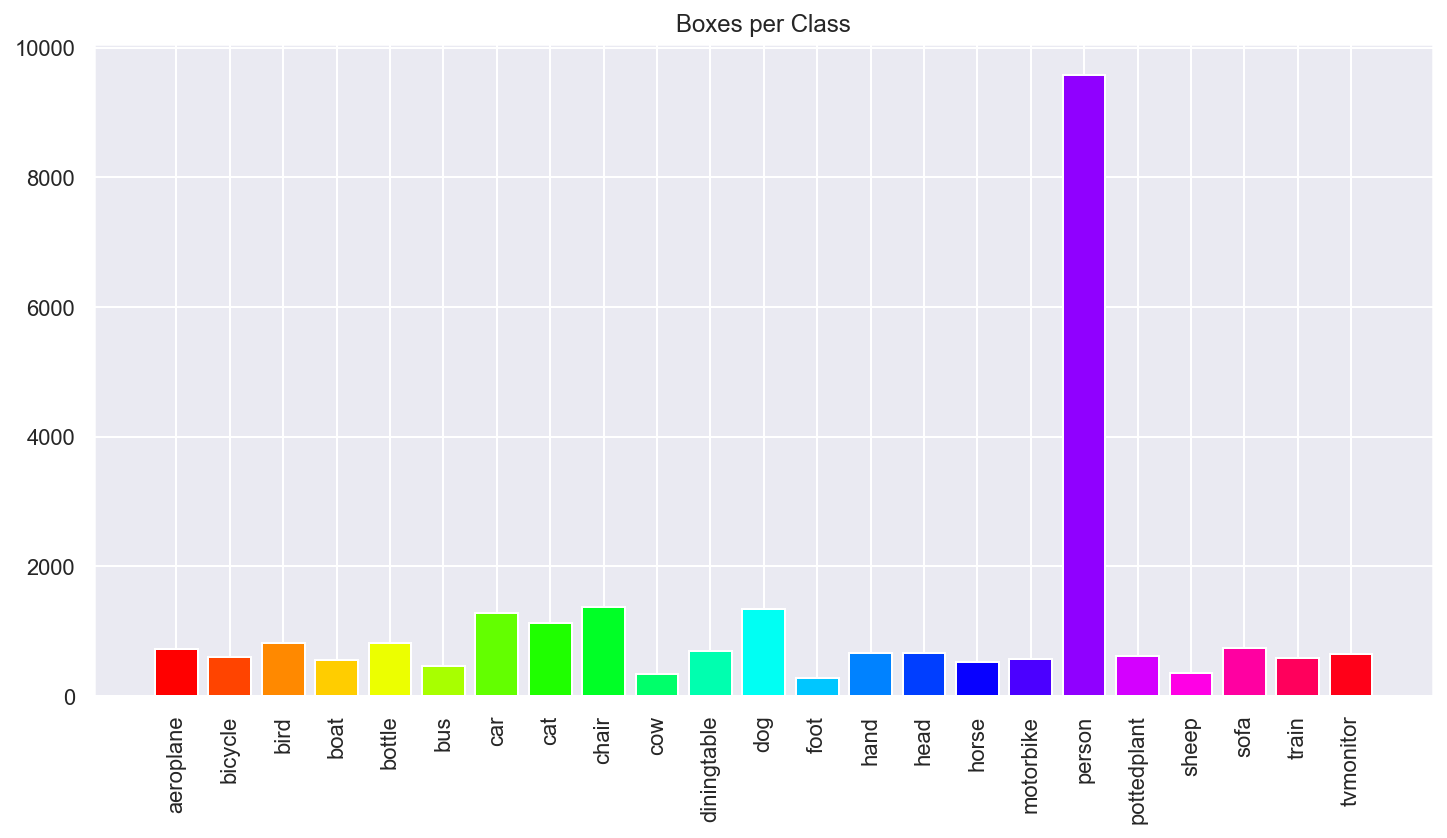

In [15]:
# Show a bar plot:
voc2012_dataset.plot_boxes_per_class(figsize=(12, 6))

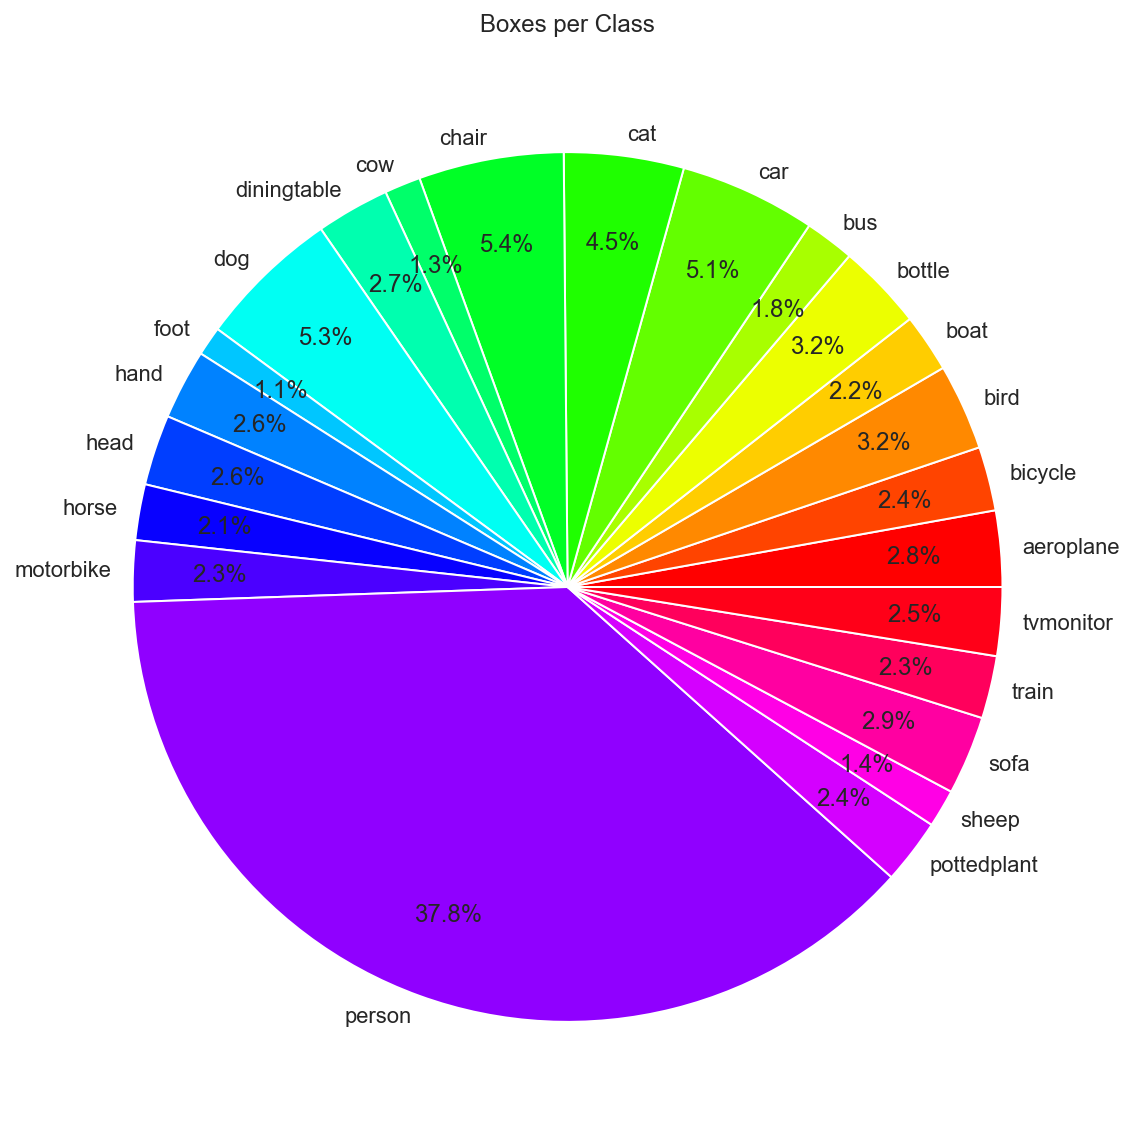

In [16]:
# Show a pie plot:
voc2012_dataset.plot_boxes_per_class(kind="pie", figsize=(10, 10))

*Note:* The VOCXMLDataFrames color_function member is used to color the classes of the bar and pie plots.

### Accessing Samples

In [17]:
voc2012_dataset[0]

(<PIL.Image.Image image mode=RGB size=486x500 at 0x14B6A28E248>,
 {'boxes': tensor([[174., 101., 349., 351.],
          [169., 104., 209., 146.],
          [278., 210., 297., 233.],
          [273., 333., 297., 354.],
          [319., 307., 340., 326.]]),
  'labels': tensor([18, 15, 14, 13, 13], dtype=torch.uint8),
  'image_id': tensor([0]),
  'area': tensor([43750.,  1680.,   437.,   504.,   399.]),
  'iscrowd': tensor([0, 0, 0, 0, 0])})

### Displaying Samples

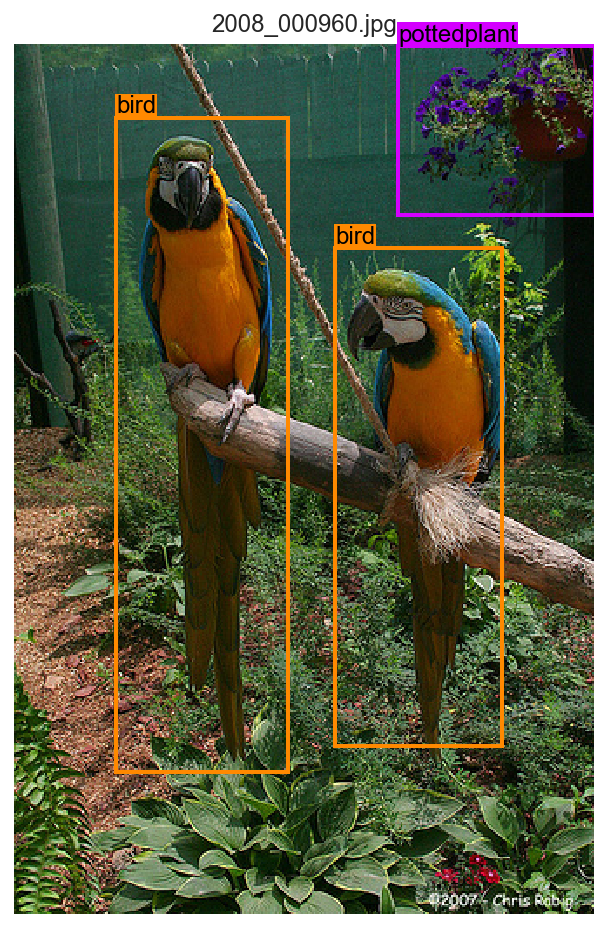

In [35]:
# Display a single sample:
voc2012_dataset.display_sample(1234)

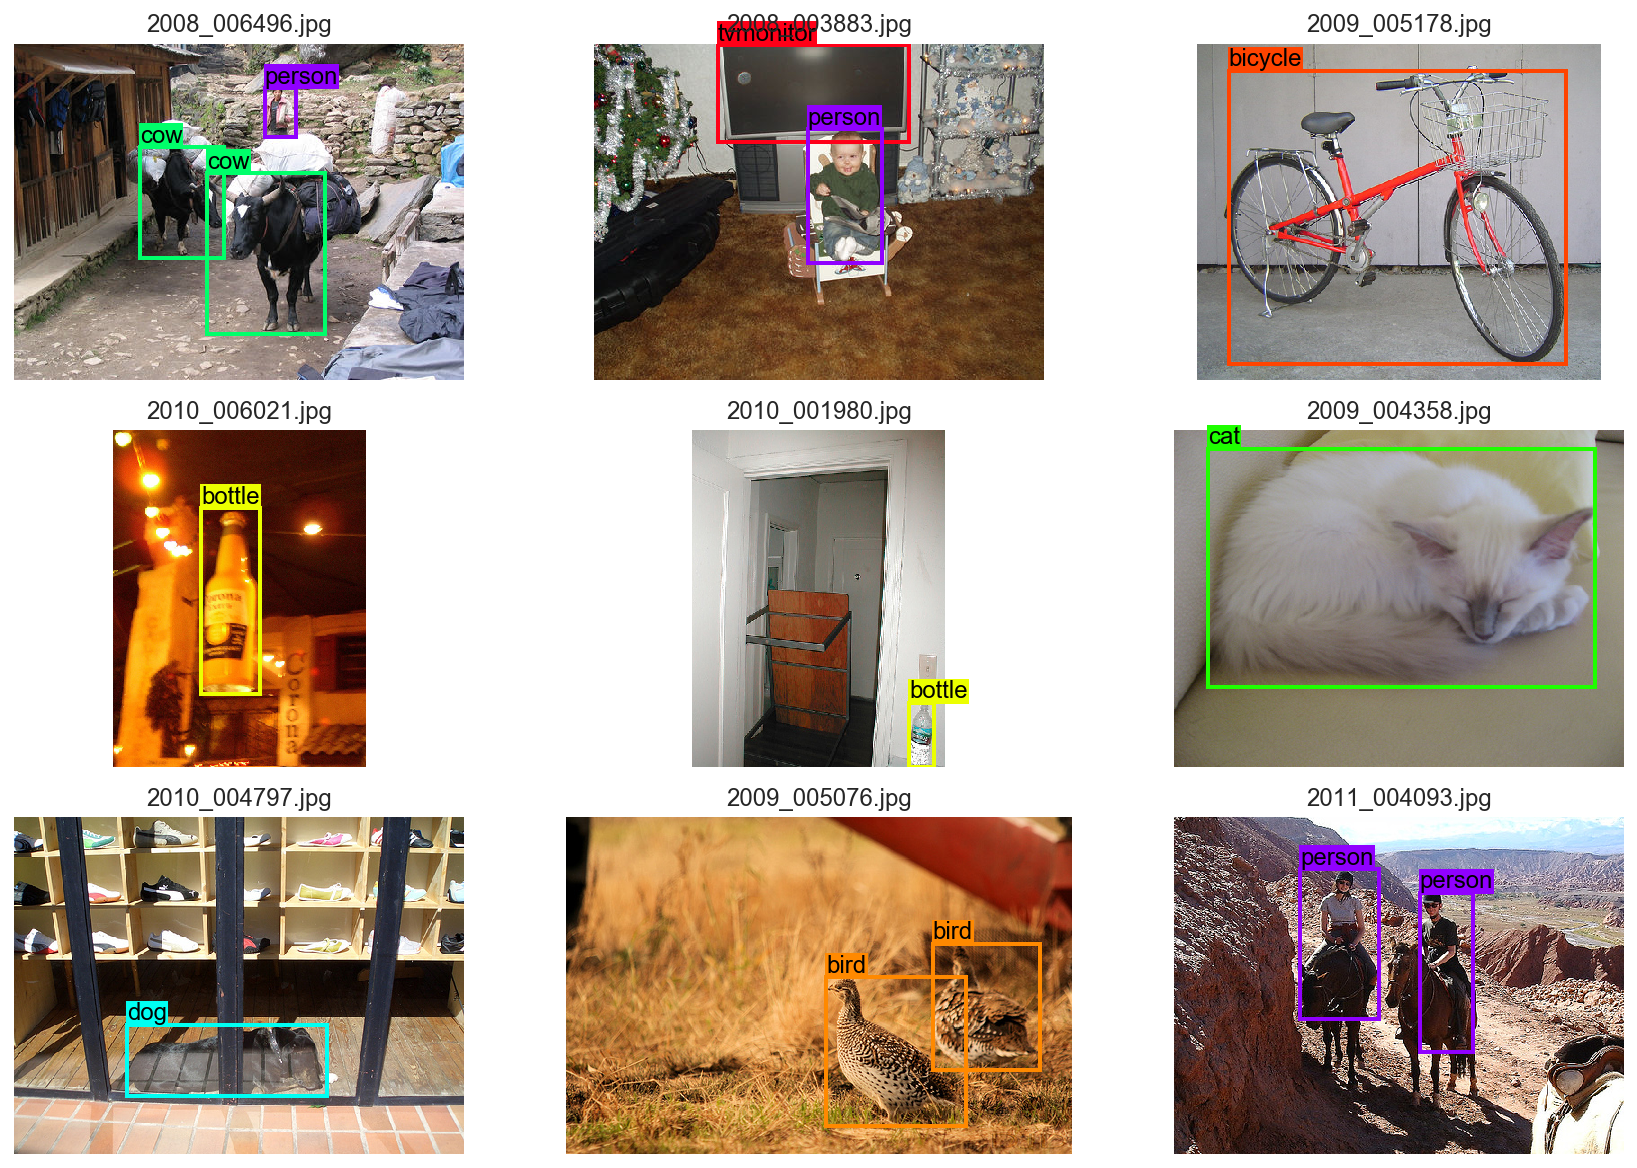

In [19]:
# Display random samples in a grid:
voc2012_dataset.display_sample_grid()

## Adding Data Augmentations
Data augmentation can be used to artificially increase the size of samples by transforming the original samples in random ways, such
as rotating an image (picking a random degree within a given interval) or flipping it vertically or horizontally (with a given probabiliy). This can easily be added to the VOCXMLDataset.
As the standard Pytorch torchvision transforms apply to samples that only contain images, it is necessary to write custom transform classes that can transform samples that contain
images and bounding box data. Currently you can find the following custom transforms in mltools.detection.transforms:

#### Data Augmentation Transforms:
* RandomAffine()
* RandomHorizontalFlip()
* RandomVerticalFlip()

#### Other Transforms:
* ToTensor()
* Resize()
* Normalize()
* Compose()

In [20]:
# Define transforms:
transforms = T.Compose([
    T.ToTensor(),
    T.RandomHorizontalFlip(0.4),
    T.RandomAffine(5, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=5)
])

In [21]:
# (1) Passing transforms to VOCXMLDataset constructor:
voc2012_augmented_dataset = VOCXMLDataset(root=data_path, 
                                          image_folder_name="JPEGImages", 
                                          annotation_folder_name="Annotations", 
                                          transforms=transforms)

# (2) Setting transforms for existing dataset:
# voc2012_dataset.transforms = transforms

In [22]:
voc2012_augmented_dataset

Dataset VOCXMLDataset
    Number of datapoints: 17125
    Root location: ..\data\VOC2012
    Number of classes: 23
    Classes: ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'foot', 'hand', 'head', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
    Compose(
        ToTensor()
        RandomHorizontalFlip(prob=0.4)
        RandomAffine(degrees=(-5, 5), translate=(0.1, 0.1), scale=(0.9, 1.1), shear=(-5, 5))
    )

### Displaying augmented Samples

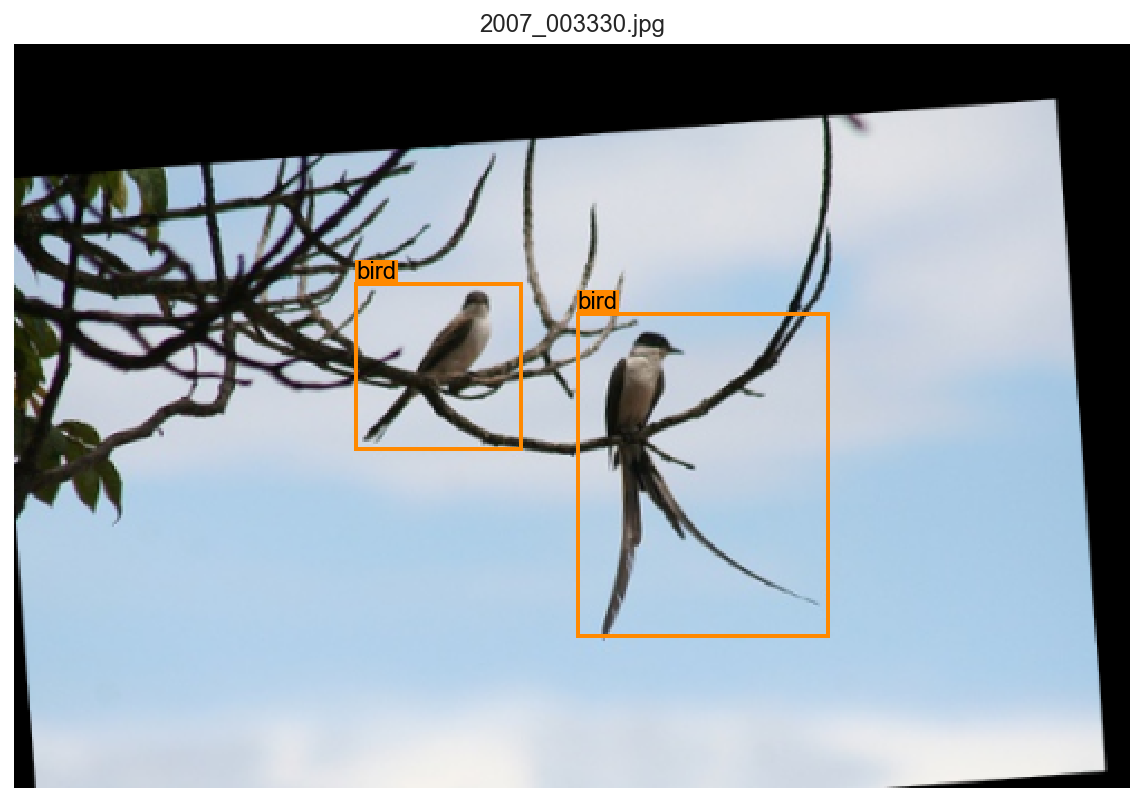

In [27]:
voc2012_augmented_dataset.display_sample(233)

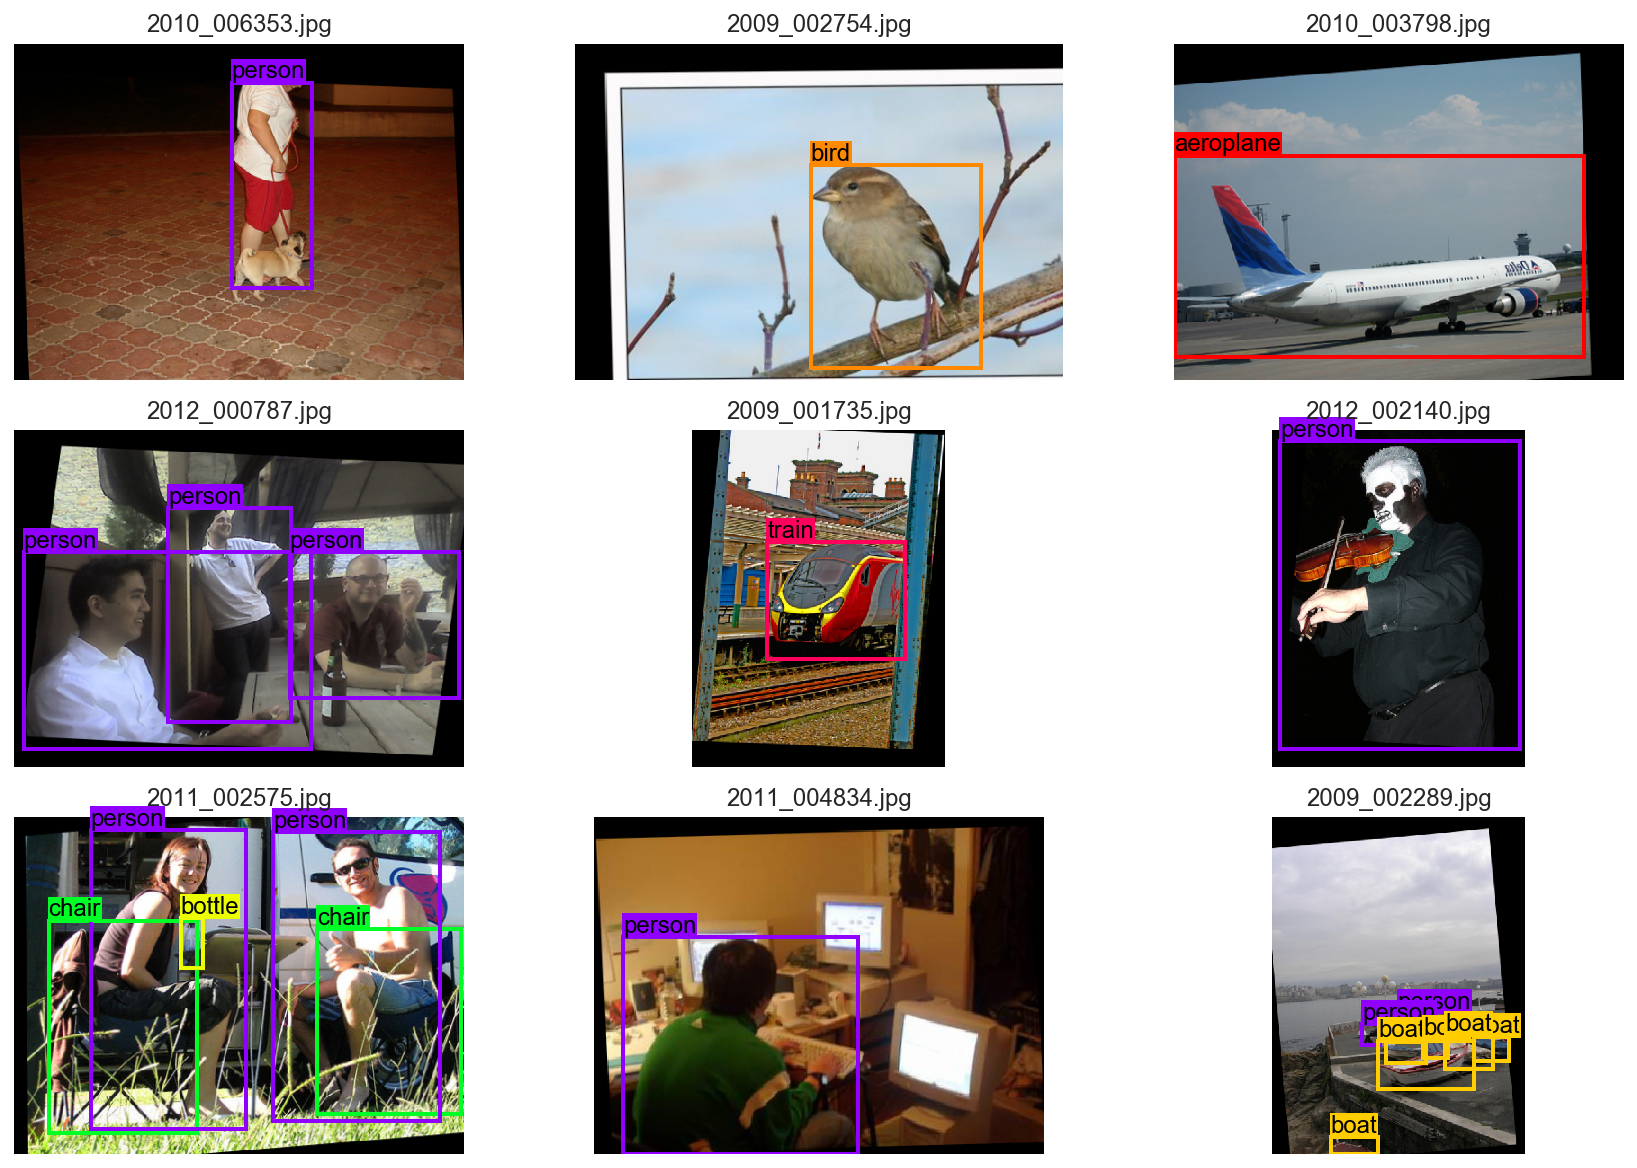

In [28]:
voc2012_augmented_dataset.display_sample_grid()